# Part 4: Predictive analysis
In this part we will train three predictive models on the data set and evaluate thier performance. The models are meant to predict the number of rentals given certain conditions (date and weather).

To train the models we use six features: hour, weekday, month, temperature, precipation, wind speed.

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime as dt

from yellowbrick.target import FeatureCorrelation

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

path = r"D:\OneDrive - Universität zu Köln\Uni\AA\Project\aa_project\Abgabe\Data"
path_fig = r"D:\OneDrive - Universität zu Köln\Uni\AA\Project\aa_project\Abgabe\Figures"

# 1. Predictive analysis perparation

## 1.1 Data import

In [159]:
#Berlin
df_b_base = pd.read_csv(path + r"\berlin_final.csv")
df_b_w = pd.read_csv(path + r"\berlin_weather.csv")

# Frankfurt
df_f_base = pd.read_csv(path + r"\frankfurt_final.csv")
df_f_w = pd.read_csv(path + r"\frankfurt_weather.csv")

In [160]:
def get_trips_berlin(datetime):
    return len(df_b_base[(df_b_base["month"] == datetime.month) & (df_b_base["date"] == datetime.day) & (df_b_base["hour"] == datetime.hour)].index)

def get_trips_frankfurt(datetime):
    return len(df_f_base[(df_f_base["month"] == datetime.month) & (df_f_base["date"] == datetime.day) & (df_f_base["hour"] == datetime.hour)].index)

In [161]:
df_f_w.drop(columns = ["sid", "Unnamed: 0"], inplace = True)
df_f_w.datetime = pd.to_datetime(df_f_w.datetime)
df_f_w["num_trips"] = df_f_w["datetime"].apply(get_trips_frankfurt)

df_b_w.drop(columns = ["sid", "Unnamed: 0"], inplace = True)
df_b_w.datetime = pd.to_datetime(df_b_w.datetime)
df_b_w["num_trips"] = df_b_w["datetime"].apply(get_trips_berlin)

In [162]:
def get_month(datetime):
    return datetime.month
def get_hour(datetime):
    return datetime.hour
def get_weekday(datetime):
    return datetime.weekday() + 1

In [163]:
df_f_w['month'] = df_f_w['datetime'].apply(get_month)
df_f_w['hour'] = df_f_w['datetime'].apply(get_hour)
df_f_w['weekday'] = df_f_w['datetime'].apply(get_weekday)

In [164]:
df_b_w['month'] = df_b_w['datetime'].apply(get_month)
df_b_w['hour'] = df_b_w['datetime'].apply(get_hour)
df_b_w['weekday'] = df_b_w['datetime'].apply(get_weekday)

In [165]:
start = dt.datetime.strptime('2019-03-15 13:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2019-03-19 08:00:00', '%Y-%m-%d %H:%M:%S')

df_b_w.drop(df_b_w[(df_b_w.datetime >= start) &
                   (df_b_w.datetime <= end)].index, inplace = True)

In [166]:
df_b = df_b_w[['month', 'weekday', 'hour', 'num_trips', 'temperature', 'precipitation', 'wind_speed']] #
y_b = df_b[['num_trips']]
X_b = df_b.drop('num_trips', axis=1)


In [167]:
df_f = df_f_w[['month', 'weekday', 'hour', 'num_trips', 'temperature', 'precipitation', 'wind_speed']] #
y_f = df_f[['num_trips']]
X_f = df_f.drop('num_trips', axis=1)


## 1.2 Feature correlation
To get a better feel 

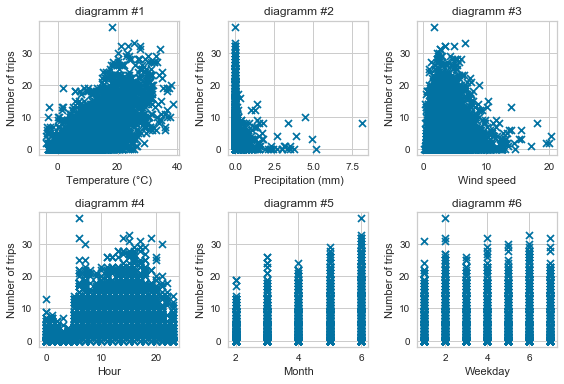

In [168]:
# df_summer = df[list(map(lambda x : str(x) in ["6", "7", "8"], df.month))].copy()

plt.subplot(2,3,1)
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of trips")
plt.title("diagramm #1")
plt.scatter(X_f["temperature"], y_f["num_trips"], marker='x')

plt.subplot(2,3,2)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of trips")
plt.title("diagramm #2")
plt.scatter(X_f["precipitation"], y_f["num_trips"], marker='x')

plt.subplot(2,3,3)
plt.xlabel("Wind speed")
plt.ylabel("Number of trips")
plt.title("diagramm #3")
plt.scatter(X_f["wind_speed"], y_f["num_trips"], marker='x')

plt.subplot(2,3,4)
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("diagramm #4")
plt.scatter(X_f["hour"], y_f["num_trips"], marker='x')

plt.subplot(2,3,5)
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.title("diagramm #5")
plt.scatter(X_f["month"], y_f["num_trips"], marker='x')

plt.subplot(2,3,6)
plt.xlabel("Weekday")
plt.ylabel("Number of trips")
plt.title("diagramm #6")
plt.scatter(X_f["weekday"], y_f["num_trips"], marker='x')

plt.tight_layout()
plt.savefig(path_fig + r'\feature_plotting.png')
plt.show()

c:\users\janfd\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
c:\users\janfd\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


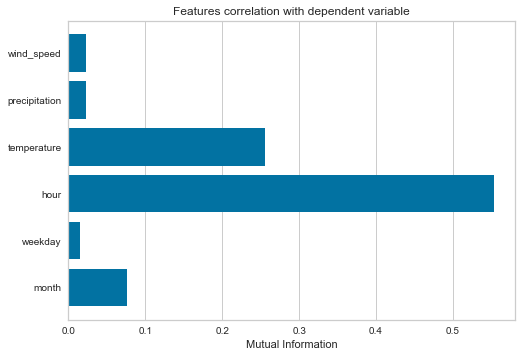

In [169]:
features = np.array(X_b.columns)

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features)

visualizer.fit(X_b, y_b, discrete_features=discrete, random_state=1)
visualizer.show()

# 2. Model training

## 2.1 Splitting and scaling data

In [170]:
X_f = StandardScaler().fit_transform(X_f)
X_b = StandardScaler().fit_transform(X_b)

- X = temperature, precipitation, wind_speed, month, weekday, hour
- y = num_trips

In [171]:
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.2)

In [172]:
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2)

In [173]:
# scaler = StandardScaler()
# scaler.fit(X_b_train)
#
# X_b_train = scaler.transform(X_b_train)
# X_b_test = scaler.transform(X_b_test)
#
# scaler.fit(X_f_train)
#
# X_f_train = scaler.transform(X_f_train)
# X_f_test = scaler.transform(X_f_test)

## 2.2 Linear Regression

In [174]:
# model = LinearRegression(fit_intercept = True)
# model.fit(X_b_train, y_b_train)
#
# model_pred = model.predict(X_b_test)
#
# print ('The R^2 of linear regression is: ', r2_score(y_b_test, model_pred))
# print ('The mean squared error of linear regression is: ', mean_squared_error(y_b_test, model_pred))

## 2.3 Polynomial Regression

### Berlin

In [175]:
num_degree = 3


In [176]:
poly_b = PolynomialFeatures(degree = num_degree)

X_b_poly = poly_b.fit_transform(X_b)

X_b_train_poly, X_b_test_poly, y_b_train_poly, y_b_test_poly = train_test_split(X_b_poly, y_b, test_size=0.3)

In [177]:
# model_poly = LinearRegression(normalize = True)
# model_poly.fit(X_b_train_poly,y_b_train_poly)
#
# y_pred = model_poly.predict(X_b_test_poly)
#
# print ('The R^2 for polynomial regression is: ', r2_score(y_b_test_poly, y_pred))
# print ('The mean squared error for polynomial regression is: ', mean_squared_error(y_b_test_poly, y_pred))

In [178]:
model_L2 = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')

model_L2.fit(X_b_train_poly, y_b_train_poly)
L2_pred = model_L2.predict(X_b_test_poly)

print ('The R^2 for ridge regession is: ', r2_score(y_b_test_poly, L2_pred))
print ('The mean squared error for ridge regession is: ', mean_squared_error(y_b_test_poly, L2_pred))

The R^2 for ridge regession is:  0.6028236537647182
The mean squared error for ridge regession is:  1110.1208470768154


In [179]:
model_L1 = Lasso(alpha = 0.1, normalize = False, max_iter = 20000)

model_L1.fit(X_b_train_poly, y_b_train_poly)
L1_pred = model_L1.predict(X_b_test_poly)

print ('The R^2 for lasso regession is: ', r2_score(y_b_test_poly, L1_pred))
print ('The mean squared error for lasso regession is: ', mean_squared_error(y_b_test_poly, L1_pred))

The R^2 for lasso regession is:  0.5186596715056415
The mean squared error for lasso regession is:  1345.3619236525499


c:\users\janfd\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177638.39189524273, tolerance: 738.2065257026477
  positive)


### Frankfurt

In [180]:
poly_f = PolynomialFeatures(degree = num_degree)

X_f_poly = poly_f.fit_transform(X_f)

X_f_train_poly, X_f_test_poly, y_f_train_poly, y_f_test_poly = train_test_split(X_f_poly, y_f, test_size=0.3)

In [181]:
# model_poly = LinearRegression(normalize = True)
# model_poly.fit(X_f_train_poly, y_f_train_poly)
#
# y_pred = model_poly.predict(X_f_test_poly)
#
# print ('The R^2 for polynomial regression is: ', r2_score(y_f_test_poly, y_pred))
# print ('The mean squared error for polynomial regression is: ', mean_squared_error(y_f_test_poly, y_pred))

In [182]:
model_L2 = Ridge(alpha = 0.1, normalize = True, solver = 'lsqr')

model_L2.fit(X_b_train_poly, y_b_train_poly)
L2_pred = model_L2.predict(X_f_test_poly)

print ('The R^2 for ridge regession is: ', r2_score(y_f_test_poly, L2_pred))
print ('The mean squared error for ridge regession is: ', mean_squared_error(y_f_test_poly, L2_pred))

The R^2 for ridge regession is:  -121.1081682492098
The mean squared error for ridge regession is:  4550.805185988259


In [183]:
model_L1 = Lasso(alpha = 0.1, normalize = False, max_iter = 20000)

model_L1.fit(X_f_train_poly, y_f_train_poly)
L1_pred = model_L1.predict(X_f_test_poly)

print ('The R^2 for lasso regession is: ', r2_score(y_f_test_poly, L1_pred))
print ('The mean squared error for lasso regession is: ', mean_squared_error(y_f_test_poly, L1_pred))

The R^2 for lasso regession is:  0.526674525842086
The mean squared error for lasso regession is:  17.640196010983292


## 2.4 Decision Tree Regression

In [192]:
tree_reg = DecisionTreeRegressor(max_depth = 6)
tree_reg.fit(X_b_train, y_b_train)

tree_pred = tree_reg.predict(X_b_test)

print ('The R^2 for lasso regession is: ', r2_score(y_b_test, tree_pred))

The R^2 for lasso regession is:  0.7577139721103521


In [186]:
tree_reg.get_depth()

6

In [187]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    tree_model = DecisionTreeRegressor(max_depth = tree_depth)
    tree_model.fit(X_b_train, y_b_train)

    dot_data = export_graphviz(tree_model, feature_names=["temperature", "precipitation", "wind_speed", "hour", "month", "weekday"])

    graph = graphviz.Source(dot_data)

    return graph

In [188]:
# plot_regression_tree_sklearn(6)

## 2.5 Neural Network

In [189]:
regr = MLPRegressor(hidden_layer_sizes=(20,20,20), random_state=1, max_iter=1000).fit(X_b_train, y_b_train)
pred = regr.predict(X_b_test)

print(r2_score(y_b_test, pred))

c:\users\janfd\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7862647709426747


In [190]:
pred = pred.reshape(len(pred),1)

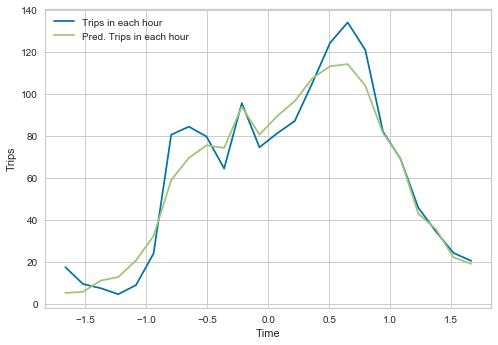

In [191]:
df_plot = pd.DataFrame()
df_plot['hour'] = X_b_test[:, 2]
# df_plot['hour'] = X_b_test.hour
df_plot['target'] = y_b_test.reset_index(drop=True)
df_plot['pred'] = pred
df_plot = df_plot.groupby(df_plot.hour).mean()
df_plot.sort_index(inplace=True)
plt.plot(df_plot.hour, df_plot.target, label='Trips in each hour')
plt.plot(df_plot.hour, df_plot.pred, label='Pred. Trips in each hour')
plt.ylabel('Trips')
plt.xlabel('Time')
plt.legend()
# plt.xlim(0, 23)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# plt.savefig('trip_hour.png')
plt.show()